# OULAD Dataset Analysis

Dataset Link: https://analyse.kmi.open.ac.uk/open_dataset

Kaggle Challange: https://www.kaggle.com/vjcalling/oulad-open-university-learning-analytics-dataset

This notebook will analyse the OULAD dataset and create new features based on the output of KMeans and then will apply SVM, MLPClassifier and Logistic Regression to analyse the results.

# Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Data Loading

Making a utility function to select data from files

In [23]:
def fetchData(filename):
	return pd.read_csv("../StudentDataset/" + filename, header=0)

In [24]:
studentInfo = fetchData("studentInfo.csv")
studentAssessment = fetchData("studentAssessment.csv")
studentVLE = fetchData("studentVle.csv")

# Data Processing

In [25]:
studentVLE["sum_of_sum_click"] = studentVLE.groupby(["id_student"])["sum_click"].transform(sum)

Indexing the data

In [26]:
studentInfo.set_index('id_student')
studentAssessment.set_index('id_student')
studentVLE.set_index('id_student')

,code_module,code_presentation,id_site,date,sum_click,sum_of_sum_click
id_student,,,,,,
28400,AAA,2013J,546652,-10,4,1435
28400,AAA,2013J,546652,-10,1,1435
28400,AAA,2013J,546652,-10,1,1435
28400,AAA,2013J,546614,-10,11,1435
28400,AAA,2013J,546714,-10,1,1435
28400,AAA,2013J,546652,-10,8,1435
28400,AAA,2013J,546876,-10,2,1435
28400,AAA,2013J,546688,-10,15,1435
28400,AAA,2013J,546662,-10,17,1435


These are the columns required

In [27]:
requiredStudentInfo=["id_student", "highest_education", "studied_credits", "num_of_prev_attempts", "final_result", "disability"]
requiredStudentAssessment=["id_student", "date_submitted", "score"]
requiredStudentVLE=["id_student", "sum_of_sum_click"]

In [28]:
studentInfo=studentInfo[requiredStudentInfo]
studentAssessment=studentAssessment[requiredStudentAssessment]
studentVLE=studentVLE[requiredStudentVLE]
studentVLE.drop_duplicates("id_student", inplace=True)

creating a function which will remove the Unwanted data.

There are a few question marks in the column 'score' which should be removed.

In [29]:
def removeUnwantedData(inputDataFrame, columnName, removeString, replaceString):
	inputDataFrame[columnName] = inputDataFrame[columnName].str.replace(removeString, replaceString)
	return inputDataFrame

In [30]:
studentAssessment = removeUnwantedData(studentAssessment, "score", "?", "0")
studentAssessment["score"] = pd.to_numeric(studentAssessment["score"])

Combining data frames

In [31]:
combinedDF = studentInfo.combine_first(studentAssessment)
combinedDF = combinedDF.combine_first(studentVLE)

In [32]:
combinedDF.set_index('id_student')
combinedDFcopy=combinedDF.copy()

Writing a function which encodes the columns and replaces the specific values in the columns

In [33]:
def encodingColumns(inputDataFrame):
	inputDataFrame=removeUnwantedData(inputDataFrame, "disability", "N", "1")
	inputDataFrame=removeUnwantedData(inputDataFrame, "disability", "Y", "2")

	inputDataFrame=removeUnwantedData(inputDataFrame, "final_result", "Fail", "1")
	inputDataFrame=removeUnwantedData(inputDataFrame, "final_result", "Withdrawn", "2")
	inputDataFrame=removeUnwantedData(inputDataFrame, "final_result", "Pass", "3")
	inputDataFrame=removeUnwantedData(inputDataFrame, "final_result", "Distinction", "4")

	inputDataFrame=removeUnwantedData(inputDataFrame, "highest_education", "No Formal quals", "1")
	inputDataFrame=removeUnwantedData(inputDataFrame, "highest_education", "Lower Than A Level", "2")
	inputDataFrame=removeUnwantedData(inputDataFrame, "highest_education", "A Level or Equivalent", "3")
	inputDataFrame=removeUnwantedData(inputDataFrame, "highest_education", "HE Qualification", "4")
	inputDataFrame=removeUnwantedData(inputDataFrame, "highest_education", "Post Graduate Qualification", "5")
	return inputDataFrame

In [34]:
combinedDF = encodingColumns(combinedDF)

In [35]:
combinedDF.isna().any()

date_submitted           True
disability               True
final_result             True
highest_education        True
id_student              False
num_of_prev_attempts     True
score                    True
studied_credits          True
sum_of_sum_click         True
dtype: bool

converting some columns to numeric

In [36]:
combinedDF["disability"] = pd.to_numeric(combinedDF["disability"])
combinedDF["final_result"] = pd.to_numeric(combinedDF["final_result"])
combinedDF["highest_education"] = pd.to_numeric(combinedDF["highest_education"])

Writing a function which will resolve all the NAN values in the dataframe

In [37]:
def resolveNANs(inputDataFrame):
	for columnName in inputDataFrame.columns:
		if inputDataFrame[columnName].dtype == "object":
			inputDataFrame[columnName] = inputDataFrame[columnName].fillna("Nothing")
		elif inputDataFrame[columnName].dtype == "int64":
			inputDataFrame[columnName] = inputDataFrame[columnName].fillna(0)
		elif inputDataFrame[columnName].dtype == "float64":
			inputDataFrame[columnName] = inputDataFrame[columnName].fillna(0.0)
	return inputDataFrame

In [38]:
combinedDF = resolveNANs(combinedDF)

In [39]:
combinedDF.isna().any()

date_submitted          False
disability              False
final_result            False
highest_education       False
id_student              False
num_of_prev_attempts    False
score                   False
studied_credits         False
sum_of_sum_click        False
dtype: bool

# Models

## KMeans

In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='random', n_clusters=2,  tol=1e-04, random_state=0).fit(combinedDF[["highest_education", "studied_credits", "num_of_prev_attempts", "final_result", "disability", "date_submitted", "score", "sum_of_sum_click"]])

labels=kmeans.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

Making a new column "procastinate" which tells if the student will procastinate based on the output from the clusters

In [42]:
combinedDFcopy["procastinate"] = labels == 1
combinedDF["procastinate"] = labels

Randomizing

In [43]:
combinedDF.sample(frac=1)

,date_submitted,disability,final_result,highest_education,id_student,num_of_prev_attempts,score,studied_credits,sum_of_sum_click,procastinate
52160,139.0,0.0,0.0,0.0,2047421.0,0.0,74.0,0.0,0.0,0
76997,53.0,0.0,0.0,0.0,40419.0,0.0,71.0,0.0,0.0,0
79041,80.0,0.0,0.0,0.0,563971.0,0.0,99.0,0.0,0.0,0
52338,209.0,0.0,0.0,0.0,167791.0,0.0,65.0,0.0,0.0,0
30525,39.0,1.0,3.0,3.0,588367.0,0.0,75.0,30.0,0.0,0
762788,0.0,0.0,0.0,0.0,609871.0,0.0,0.0,0.0,128.0,0
169513,221.0,0.0,0.0,0.0,633923.0,0.0,100.0,0.0,0.0,0
10411,60.0,2.0,2.0,3.0,1780737.0,0.0,100.0,60.0,0.0,0
173369,207.0,0.0,0.0,0.0,651628.0,0.0,0.0,0.0,0.0,0
46284,40.0,0.0,0.0,0.0,300594.0,0.0,44.0,0.0,0.0,0


## Visualization

In [44]:
inTime, procastinate = [x for _, x in combinedDF.groupby(combinedDF['procastinate'] == 0)]
inTime=inTime.head(100)
procastinate=procastinate.head(100)

In [45]:
procastinate

,date_submitted,disability,final_result,highest_education,id_student,num_of_prev_attempts,score,studied_credits,sum_of_sum_click,procastinate
0,18.0,1.0,3.0,4.0,11391.0,0.0,78.0,240.0,1435.0,0
1,22.0,1.0,3.0,4.0,28400.0,0.0,70.0,60.0,0.0,0
2,17.0,2.0,2.0,3.0,30268.0,0.0,72.0,60.0,0.0,0
3,26.0,1.0,3.0,3.0,31604.0,0.0,69.0,60.0,0.0,0
4,19.0,1.0,3.0,2.0,32885.0,0.0,79.0,60.0,0.0,0
5,20.0,1.0,3.0,3.0,38053.0,0.0,70.0,60.0,0.0,0
6,18.0,1.0,3.0,4.0,45462.0,0.0,72.0,60.0,0.0,0
7,19.0,1.0,3.0,3.0,45642.0,0.0,72.0,120.0,0.0,0
8,9.0,1.0,3.0,3.0,52130.0,0.0,71.0,90.0,0.0,0
9,18.0,1.0,3.0,5.0,53025.0,0.0,68.0,60.0,0.0,0


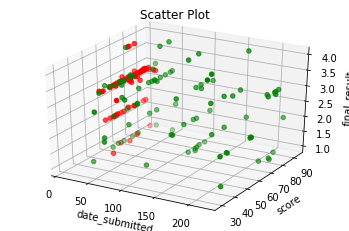

In [47]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(procastinate["date_submitted"], procastinate["score"], procastinate["final_result"], c="r", marker="o")
ax.scatter(inTime["date_submitted"], inTime["score"], inTime["final_result"], c="g", marker="o")

ax.set_xlabel("date_submitted")
ax.set_ylabel("score")
ax.set_zlabel("final_result")
plt.title("Scatter Plot")
plt.show()

Writing a function which will show the confusion matrix of the model

In [55]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Data Splitting

In [49]:
y=combinedDF["procastinate"]
X=combinedDF.drop("procastinate", axis=1)
X.set_index('id_student', inplace=True)

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50)

## MLPClassifier

In [53]:
from sklearn.neural_network import MLPClassifier

ann = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
ann.fit(X_train, y_train.values.ravel())
predictions = ann.predict(X_test)
score = ann.score(X_test, y_test)
loss_values = ann.loss_curve_
print("Accuracy: ", score * 100)

Accuracy:  99.96959699122817


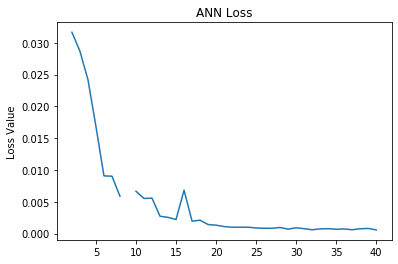

In [54]:
plt.title("ANN Loss")
plt.ylabel("Loss Value")
plt.plot(loss_values)
plt.show()

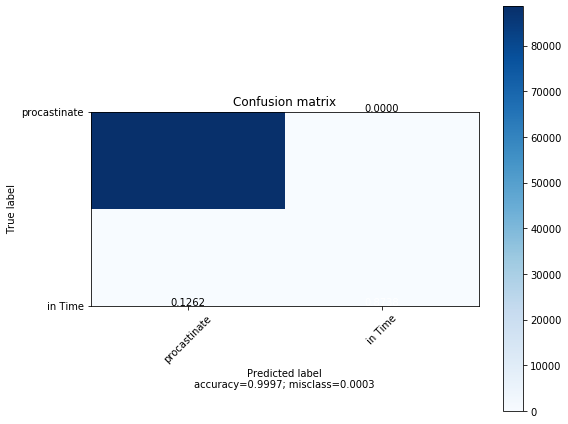

In [56]:
plot_confusion_matrix(confusion_matrix(y_test,predictions), ["procastinate", "in Time"])

In [57]:
from sklearn.metrics import classification_report
print("Classification Report\n", classification_report(y_test,predictions))

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     88593
           1       1.00      0.87      0.93       214

    accuracy                           1.00     88807
   macro avg       1.00      0.94      0.97     88807
weighted avg       1.00      1.00      1.00     88807



## Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print("Accuracy: ", score * 100)

Accuracy:  99.99549585055232


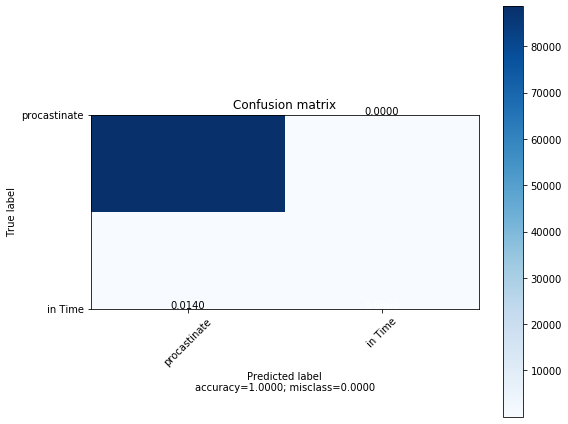

In [60]:
plot_confusion_matrix(confusion_matrix(y_test,predictions), ["procastinate", "in Time"])

In [61]:
print("Classification Report\n", classification_report(y_test,predictions))

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     88593
           1       1.00      0.99      0.99       214

    accuracy                           1.00     88807
   macro avg       1.00      0.99      1.00     88807
weighted avg       1.00      1.00      1.00     88807



## SVM

In [62]:
from sklearn.svm import SVC

svmClassifier=SVC(kernel='linear')
svmClassifier.fit(X_train.head(1000), y_train[:1000])
predictions = svmClassifier.predict(X_test)
score = svmClassifier.score(X_test, y_test)
print("Accuracy: ", score * 100)

Accuracy:  99.98648755165696


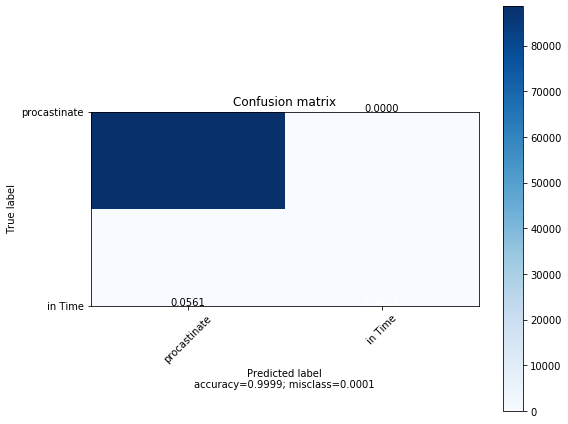

In [64]:
plot_confusion_matrix(confusion_matrix(y_test,predictions), ["procastinate", "in Time"])

In [65]:
print("Classification Report\n", classification_report(y_test,predictions))

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     88593
           1       1.00      0.94      0.97       214

    accuracy                           1.00     88807
   macro avg       1.00      0.97      0.99     88807
weighted avg       1.00      1.00      1.00     88807

